In [1]:
import os
import glob
import pickle

import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# /data/MAR2_al/MAR2_hpl/65k_64_56/round0/preprocessing/round0.pkl

In [9]:
cores = '65k_64_56'

BASE_DIR     = f"../../data/MAR2_al/MAR2_hpl/{cores}/"   # point this at the “14” folder
IDLE_POWER   = 2.51                                  # watts, per core
ASSUMED_PMAX = 2.83                                 # watts, per core at max‐freq
DATA_DIR     = f"../../results/{cores}/"

In [18]:
import os
import glob
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# --- 1. Load a sample MAR2_hpl round -------------------
def load_round_pkl(base_dir, round_name="round0"):
    """
    Load the roundX.pkl for a given HPL configuration
    """
    pkl_path = os.path.join(base_dir, round_name, "preprocessing", f"{round_name}.pkl")

    print(pkl_path)
    
    with open(pkl_path, "rb") as f:
        data = pickle.load(f)
    return data

# --- 2. Derive the parameters f_ij, P_ij, barP -------------------
def derive_performance_and_power(data):
    """
    Vectorized version to derive f_ij (throughput) and P_ij (power) per core-frequency level,
    avoiding nested loops over cores and frequencies.
    """
    # Throughput: mperf/aperf
    perf = data["mperf_core"] / data["aperf_core"]
    
    # Power proxy
    power_proxy = data.get("power_proxy")
    if power_proxy is None:
        power_proxy = data["temp_core"].diff().fillna(0)
    
    # Unique frequency levels
    freq_df = data["clk_ref_core"]
    freq_levels = np.unique(freq_df.values)
    
    # Prepare result DataFrames
    cores = perf.columns
    f_ij = pd.DataFrame(index=cores, columns=freq_levels, dtype=float)
    P_ij = pd.DataFrame(index=cores, columns=freq_levels, dtype=float)
    
    # Vectorized grouping by frequency (loop only over freq levels)
    for freq in freq_levels:
        mask = (freq_df == freq)
        # mask is a DataFrame of booleans; perf.where(mask) retains per-core values where freq matches
        f_ij[freq] = perf.where(mask).mean(axis=0)
        P_ij[freq] = power_proxy.where(mask).mean(axis=0)
    
    # Idle power at minimum frequency
    min_freq = freq_levels.min()
    barP = P_ij[min_freq].mean()
    
    return f_ij, P_ij, barP


# --- 3. Estimate Thermal Conductance GS -------------------
def estimate_conductance(data):
    """
    Vectorized estimation of GS_{l,i} = Cov(P_i, T_l) / Var(P_i)
    for all cores i→l in one go.
    """
    # 1. Extract and center the data matrices
    temp_df = data["temp_core"]
    power_proxy = data.get("power_proxy")
    if power_proxy is None:
        power_proxy = data["temp_core"].diff().fillna(0)
    
    # Convert to numpy arrays: shape (T, N)
    Y = temp_df.values
    X = power_proxy.values
    T, N = X.shape
    
    # Center columns
    Xc = X - X.mean(axis=0, keepdims=True)
    Yc = Y - Y.mean(axis=0, keepdims=True)
    
    # 2. Covariance matrix: shape (N, N), cov[i, l] = Cov(X_i, Y_l)
    cov = (Xc.T @ Yc) / T
    
    # 3. Variance of each X_i: shape (N,)
    var = np.sum(Xc**2, axis=0) / T
    
    # 4. Build GS matrix: GS[l, i] = cov[i, l] / var[i]
    GS_mat = cov.T / var[np.newaxis, :]
    
    # 5. Wrap in DataFrame with proper labels
    cores = temp_df.columns
    GS = pd.DataFrame(GS_mat, index=cores, columns=cores)
    return GS


# --- 4. Visualization Helpers -------------------
def plot_time_series(data, metric, cores_to_plot=None):
    """
    Plot time series for a given metric (e.g., 'temp_core', 'clk_ref_core').
    """
    df = data[metric]
    if cores_to_plot is None:
        cores_to_plot = df.columns[:4]  # first 4 cores
    plt.figure(figsize=(10, 4))
    for core in cores_to_plot:
        plt.plot(df.index, df[core], label=f"core {core}")
    plt.title(metric)
    plt.xlabel("Time")
    plt.ylabel(metric)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [19]:
data = load_round_pkl(BASE_DIR)

../../data/MAR2_al/MAR2_hpl/65k_64_56/round0/preprocessing/round0.pkl


In [20]:
f_ij, P_ij, barP = derive_performance_and_power(data)

In [21]:
# Display derived tables
print("Performance f_ij (cores x freq):")
display(f_ij)

print("\nPower P_ij (cores x freq):")
display(P_ij)

print(f"\nIdle power (barP): {barP:.2f} W")

Performance f_ij (cores x freq):


,390494000,390502560,390511040,390519440,390527760,390536000,390544400,390552880,390561760,390570800,...,563752240,563762240,563772640,563782800,563793040,563803280,563813680,563824080,563834400,563844480
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.73647,0.735454,0.737387,0.736256,0.73651,0.736416,0.736549,0.736847,0.736641,0.736608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Power P_ij (cores x freq):


,390494000,390502560,390511040,390519440,390527760,390536000,390544400,390552880,390561760,390570800,...,563752240,563762240,563772640,563782800,563793040,563803280,563813680,563824080,563834400,563844480
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.844674e+19,1.844674e+19,0.0,1.844674e+19,0.0,0.0,0.0,1.844674e+19,0.0,1.844674e+19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Idle power (barP): 0.00 W


In [22]:
GS = estimate_conductance(data)

print("\nThermal Conductance GS (T_l = Σ GS_{l i} * P_i + ...):")
display(GS)


Thermal Conductance GS (T_l = Σ GS_{l i} * P_i + ...):


,0,1,2,3,4,5,6,7,8,9,...,102,103,104,105,106,107,108,109,110,111
0,-3.375916e-20,-1.798640e-22,7.821444e-21,-5.756970e-21,-1.404698e-20,7.786039e-21,-4.404951e-20,-4.681743e-20,-6.572142e-20,-1.627779e-20,...,1.033204e-20,1.615547e-20,9.349349e-21,1.983727e-20,2.072060e-20,-4.904694e-21,3.320380e-21,2.164861e-21,1.351755e-20,-5.549661e-21
1,-1.674043e-20,-3.825851e-20,-5.869759e-21,-6.658022e-21,-2.417370e-20,-9.460187e-21,-4.375609e-20,-4.742997e-20,-6.276754e-20,-1.437862e-20,...,2.213614e-20,2.403957e-20,1.812248e-20,2.590963e-20,2.853964e-20,2.110086e-21,3.426831e-21,-7.175990e-21,1.337236e-20,3.263260e-21
2,-9.996247e-21,-9.207829e-21,-2.136233e-20,-9.786189e-21,-1.977625e-20,-1.259211e-21,-4.147778e-20,-4.682921e-20,-6.925609e-20,-1.508581e-20,...,1.220531e-20,2.063551e-20,1.183031e-20,2.229891e-20,2.171050e-20,-3.013561e-21,1.563941e-21,-4.413601e-21,1.364558e-20,-2.533381e-21
3,-2.254010e-21,2.229785e-21,1.478673e-22,-3.587976e-20,-2.380499e-20,7.959213e-21,-7.029778e-20,-6.906553e-20,-9.671147e-20,-3.344560e-20,...,4.753782e-21,1.672189e-20,1.106271e-20,1.984237e-20,1.943362e-20,-8.962429e-21,1.151665e-20,-2.276544e-21,1.476310e-20,-1.169005e-20
4,-1.414949e-20,-9.967716e-21,1.111047e-21,-9.649799e-21,-4.686800e-20,-4.490036e-21,-5.287764e-20,-5.270913e-20,-6.875136e-20,-1.712101e-20,...,1.425951e-20,1.973051e-20,9.004453e-21,2.112538e-20,2.491936e-20,-5.086891e-21,-1.791923e-21,-7.242906e-21,9.624721e-21,-2.955918e-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,3.318769e-21,1.404413e-20,1.730292e-20,-9.261308e-22,-9.597152e-21,2.715697e-20,-5.801766e-20,-4.691600e-20,-7.647602e-20,-2.529850e-20,...,-8.639697e-21,4.883660e-21,-9.020430e-21,2.872523e-21,2.446159e-21,-4.797233e-20,-1.147851e-20,-1.006373e-20,7.388368e-21,-1.609789e-20
108,4.376306e-23,6.806493e-21,8.768694e-21,-3.247397e-21,-1.264199e-20,1.949484e-20,-5.442275e-20,-5.254235e-20,-6.976467e-20,-2.413932e-20,...,-6.077281e-21,-4.965426e-22,-6.068151e-21,-3.138173e-22,2.980906e-21,-2.791249e-20,-3.000451e-20,-1.775384e-20,4.689170e-21,-2.155724e-20
109,2.860320e-21,5.528174e-21,1.112354e-20,-6.410321e-21,-1.534098e-20,1.448453e-20,-6.022417e-20,-5.276927e-20,-7.717588e-20,-2.244178e-20,...,3.589516e-21,1.316321e-20,2.732769e-21,1.221297e-20,1.449758e-20,-1.798177e-20,-5.725726e-21,-4.270251e-20,7.951086e-21,-1.338895e-20
110,-2.433311e-21,2.663952e-21,1.098058e-20,-2.885744e-21,-1.595660e-20,1.732050e-20,-5.003182e-20,-5.187835e-20,-6.884355e-20,-1.805106e-20,...,1.949761e-21,8.360201e-21,9.214586e-22,6.006317e-21,1.065495e-20,-1.994207e-20,-6.335601e-21,-1.116406e-20,-1.649129e-20,-1.369399e-20


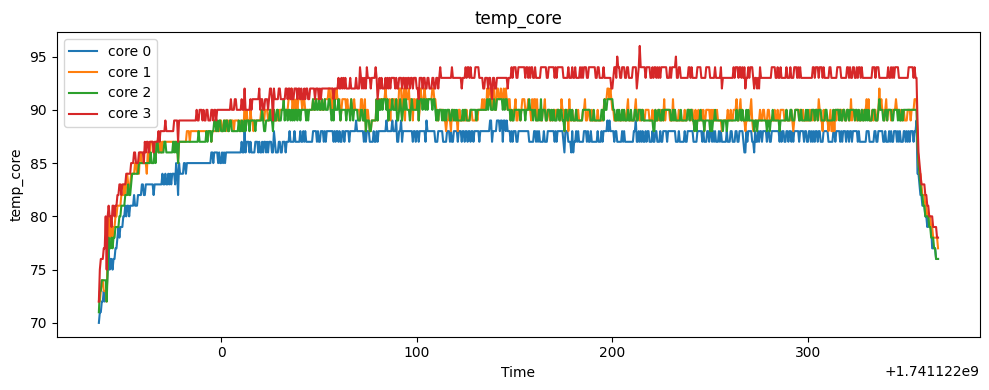

In [41]:
# Example visualizations
plot_time_series(data, "temp_core")